In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', False if tf.config.list_physical_devices('GPU') == [] else True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.8.0
Is using GPU? True
Num GPUs Available:  1


In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%capture
!unzip /content/drive/MyDrive/ML/training_all.zip

In [5]:
train_path = '/content/training'
# valid_path = 'dataset_rahin/validation/gallery'

In [6]:
# useful for getting number of classes
folders = glob(train_path+'/*')

print(len(folders))

101


In [7]:
# add preprocessing layer to the front of ResNet50
resnet50 = tf.keras.applications.ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train ResNet50 weights
for layer in resnet50.layers:
  layer.trainable = False

resnet50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [8]:
# our layers - you can add more if you want
x = Flatten()(resnet50.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet50.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
# Make last 4 layers trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_2_conv').trainable = True
model.get_layer('conv5_block3_1_conv').trainable = True
model.get_layer('conv5_block2_3_conv').trainable = True

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3)

# test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='training')

test_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset='validation')




# training_set,test_set=train_test_split(training_set,test_size=0.3,random_state=421)

Found 43455 images belonging to 101 classes.
Found 18565 images belonging to 101 classes.


In [12]:
from keras.callbacks import LearningRateScheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr


In [ ]:
# fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_RESNET50_TL_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        ),
        LearningRateScheduler(lr_scheduler, verbose=1)
    ]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
 443/1358 [========>.....................] - ETA: 8:25 - loss: 3.4857 - accuracy: 0.2154

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 605/1358 [============>.................] - ETA: 6:53 - loss: 3.3946 - accuracy: 0.2334

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


 728/1358 [===============>..............] - ETA: 5:43 - loss: 3.3277 - accuracy: 0.2481

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33 bytes but only got 32. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag)


1358/1358 [==============================] - 1084s 788ms/step - loss: 3.1272 - accuracy: 0.2911 - val_loss: 3.3348 - val_accuracy: 0.2516 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
1358/1358 [==============================] - 1051s 774ms/step - loss: 2.6142 - accuracy: 0.3952 - val_loss: 3.3118 - val_accuracy: 0.2818 - lr: 8.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
1358/1358 [==============================] - 1042s 767ms/step - loss: 2.4105 - accuracy: 0.4307 - val_loss: 3.1335 - val_accuracy: 0.2956 - lr: 6.1413e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
1358/1358 [==============================] - 1022s 753ms/step - loss: 2.2757 - accuracy: 0.4584 - val_loss: 3.0548 - val_accuracy: 0.3194 - lr: 3.7715e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20
1358/1358 [========

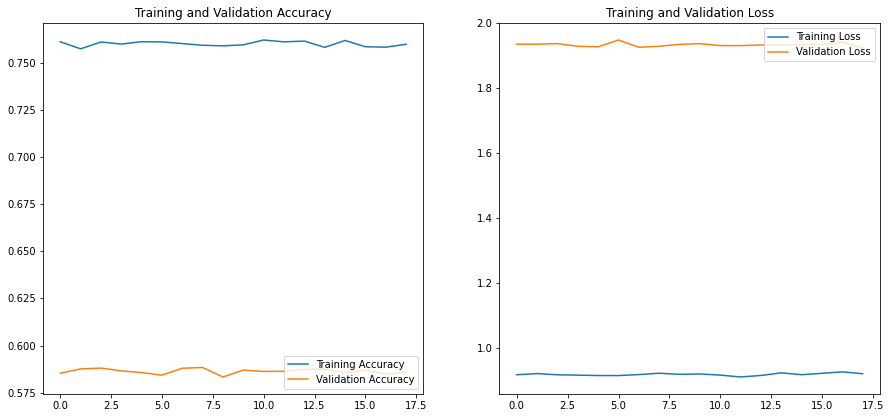

In [ ]:
# accuracies
accs = r.history['accuracy']
val_accs = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()